In [ ]:
cat_cols= df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

### Univariate Analysis

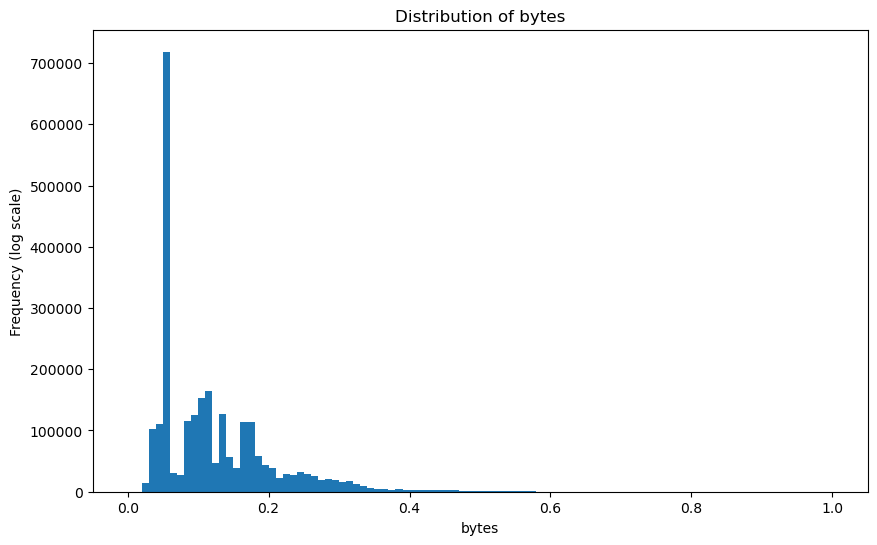

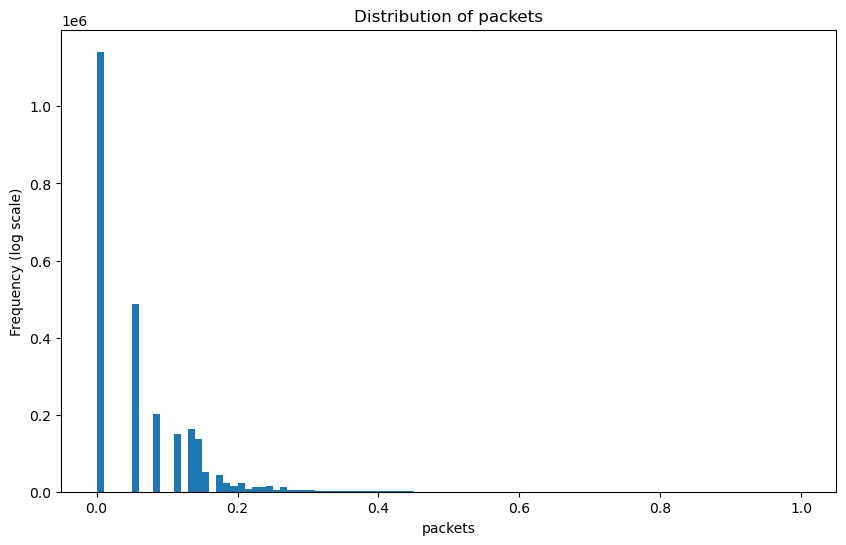

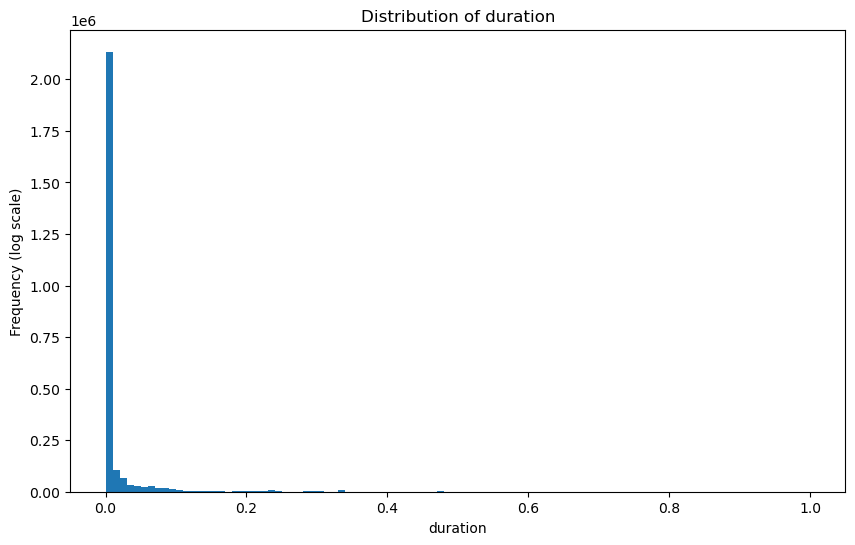

In [172]:
univars = ['bytes', 'packets', 'duration']
# Set the figure size
for u in univars:
    plt.figure(figsize=(10, 6))
    # Generate histogram for bytes using a logarithmic scale
    plt.hist(x=df[u], bins=100, range=(df[u].min(), df[u].max()))
    # Set the x-axis label
    plt.xlabel(u)
    # Set the y-axis label
    plt.ylabel('Frequency (log scale)')
    # Set the title
    plt.title('Distribution of ' + u)
    # Show the plot
    plt.show()

In [1]:
### MAIN 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse
import torch

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

print(torch.cuda.get_device_name(0))

def remove_million(val):
    """
    Removes the 'M' or 'K' suffix from a string and converts it to a numeric value.

    Args:
        val (str or int): The value to be processed. If it is a string, it should contain a suffix 'M' or 'K'.

    Returns:
        str or int: The processed value. If the input is a string, it is converted to an integer.

    Example:
        >>> remove_million('1.5 M')
        1500000
        >>> remove_million('2.3 K')
        2300
        >>> remove_million(100)
        100
    """
    if type(val) is str:                
        val = val.strip()
        if ' M' in val:                    
            val = val.replace('.', '')
            val = val.replace(' M', '00000')  
        if ' K' in val:                    
            val = val.replace('.', '')
            val = val.replace(' K', '000')                
        return val
    elif type(val) is int:
        return val
    
def ip_process(x: pd.DataFrame, ip : str):
    ip_1 = []
    ip_2 = []
    ip_3 = []
    ip_4 = []
    mod_dict = {'10200':4, '10455':6, '10710':7, '10965':8, '11475':9, '11730':10, '12495':12, '13005':13,
                '13515':14, '13770':16, '14025':17, '14280':18, '14535':19, '14790':20, '15045':21, '15300':22,
                '15555':23, '15810':24, '16065':25, '16320':26, '16575':27, '16830':28, '17085':29, '17340':31,
                '17595':32, '17850':33}
    c = "src_ip_addr" if ip == "src_" else "dst_ip_addr"
    for value in x[c]:
        if "." in str(value):
            a = value.split(".", 4)
            ip_1.append(a[0])
            ip_2.append(a[1])
            ip_3.append(a[2])
            ip_4.append(a[3])
        elif "DNS" in str(value):
            b = np.array([3, 3, 3, 3])
            ip_1.append(b[0])
            ip_2.append(b[1])
            ip_3.append(b[2])
            ip_4.append(b[3])
        elif "_" in str(value):
            p = value.split("_", 2)
            if "OPENSTACK" in p[0]:
                b = np.array([2, 2, 2, 2])
            elif "EXT" in p[0]:
                b = np.array([1, 1, 1, 1])
            else:
                if (int(p[0]) % 255)==0:
                    b = np.array([mod_dict[p[0]], mod_dict[p[0]], mod_dict[p[0]], int(p[1])])
                b = np.array([(int(p[0]) % 255), (int(p[0]) % 255), (int(p[0]) % 255), int(p[1])])
            ip_1.append(b[0])
            ip_2.append(b[1])
            ip_3.append(b[2])
            ip_4.append(b[3])
    
    ip_data = pd.DataFrame({(ip+'ip_1'): ip_1, (ip+'ip_2'): ip_2, (ip+'ip_3'): ip_3, (ip+'ip_4'): ip_4},dtype=np.float64)
    return ip_data

def hex_to_tcp_flags(hex_value):
    """
    Converts a hexadecimal value to TCP flags.

    Args:
        hex_value (str): The hexadecimal value to convert.

    Returns:
        str: The TCP flags represented as a string.

    Example:
        >>> hex_to_tcp_flags('0x52')
        '.E.A..S.'
    """
    binary_value = bin(int(hex_value, 16))[2:].zfill(8)
    flags = ['C', 'E', 'U', 'A', 'P', 'R', 'S', 'F']
    tcp_flags = ''.join([flags[i] if bit == '1' else '.' for i, bit in enumerate(binary_value)])
    return tcp_flags


Using GPU
NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
external_csv = []
openstack_csv = []
import os
for dirname, _, filenames in os.walk("../data/traffic/"):
    for filename in filenames:
        if 'external' in filename:
            fx = os.path.join(dirname, filename)
            external_csv.append(fx)            
            print(fx)
        elif 'internal' in filename:
            fx = os.path.join(dirname, filename)
            openstack_csv.append(fx)
            print(fx)

../data/traffic/ExternalServer\CIDDS-001-external-week1.csv
../data/traffic/ExternalServer\CIDDS-001-external-week2.csv
../data/traffic/ExternalServer\CIDDS-001-external-week3.csv
../data/traffic/ExternalServer\CIDDS-001-external-week4.csv
../data/traffic/OpenStack\CIDDS-001-internal-week1.csv
../data/traffic/OpenStack\CIDDS-001-internal-week2.csv
../data/traffic/OpenStack\CIDDS-001-internal-week3.csv
../data/traffic/OpenStack\CIDDS-001-internal-week4.csv


In [5]:
csvs = external_csv + openstack_csv
df = pd.concat(objs=[pd.read_csv(fp, encoding='utf-8') for fp in csvs], ignore_index=True, copy=False)

# Rename columns
df = df.rename(str.lower, axis='columns')
df = df.rename(str.strip, axis='columns')
df.rename(columns={
            'date first seen': 'date_first_seen', 
            'src ip addr': 'src_ip_addr',
            'src pt': 'src_pt',
            'dst ip addr': 'dst_ip_addr',
            'dst pt': 'dst_pt',
            'attacktype': 'attack_type',
            'attackid': 'attack_id',
            'attackdescription': 'attack_description',
            'class': 'label'
        }, inplace=True)

C:\Users\cupca\AppData\Local\Temp\ipykernel_3536\1593841806.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(objs=[pd.read_csv(fp, encoding='utf-8') for fp in csvs], ignore_index=True, copy=False)
C:\Users\cupca\AppData\Local\Temp\ipykernel_3536\1593841806.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(objs=[pd.read_csv(fp, encoding='utf-8') for fp in csvs], ignore_index=True, copy=False)
C:\Users\cupca\AppData\Local\Temp\ipykernel_3536\1593841806.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(objs=[pd.read_csv(fp, encoding='utf-8') for fp in csvs], ignore_index=True, copy=False)
C:\Users\cupca\AppData\Local\Temp\ipykernel_3536\1593841806.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(objs

In [6]:
df = df.loc[(df["date_first_seen"]>="2017-03-17 14:18:05") & (df["date_first_seen"]<="2017-03-20 17:42:17")]
df.reset_index(drop=True, inplace=True)

In [7]:
# Remove million suffix from 'bytes' column
df['bytes'] = df['bytes'].apply(remove_million)
df['bytes'] = pd.to_numeric(df['bytes'], errors='raise', downcast='float')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2619092 entries, 0 to 2619091
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date_first_seen     object 
 1   duration            float64
 2   proto               object 
 3   src_ip_addr         object 
 4   src_pt              int64  
 5   dst_ip_addr         object 
 6   dst_pt              float64
 7   packets             int64  
 8   bytes               float32
 9   flows               int64  
 10  flags               object 
 11  tos                 int64  
 12  label               object 
 13  attack_type         object 
 14  attack_id           object 
 15  attack_description  object 
dtypes: float32(1), float64(2), int64(4), object(9)
memory usage: 309.7+ MB


In [9]:
df.count()

date_first_seen       2619092
duration              2619092
proto                 2619092
src_ip_addr           2619092
src_pt                2619092
dst_ip_addr           2619092
dst_pt                2619092
packets               2619092
bytes                 2619092
flows                 2619092
flags                 2619092
tos                   2619092
label                 2619092
attack_type           2619092
attack_id             2619092
attack_description    2619092
dtype: int64

In [10]:
# Remove NA and INF values
print("N/A rows before preproc", df.isna().any(axis=1).sum())
df.replace([np.inf, -np.inf], np.nan, inplace=True)
print("N/A rows after preproc", df.isna().any(axis=1).sum())
df.dropna(inplace=True)

N/A rows before preproc 0
N/A rows after preproc 0


In [11]:
# Convert hexadecimal TCP flags to custom format
df["flags"] = df["flags"].apply(lambda x:hex_to_tcp_flags(x) if '0x' in x else x)
df['flags'] = df['flags'].apply(lambda x: '.' * (8 - len(str(x))) + str(x))

In [12]:
# One-hot encode TCP flags
df['flags'] = df['flags'].str.strip()
data_df = df['flags'].apply(func=lambda flag_str: [0 if c == '.' else 1 for c in flag_str]).to_list()
columns_df = ['tcp_con','tcp_ech','tcp_urg', 'tcp_ack', 'tcp_psh', 'tcp_rst', 'tcp_syn', 'tcp_fin']
ohe_flag_data = pd.DataFrame(data=data_df,columns=columns_df,dtype=int)
flags_idx = df.columns.get_loc('flags')
for i, c in enumerate(ohe_flag_data.columns):
    df.insert(loc=flags_idx+i, column=c, value=ohe_flag_data[c])

In [13]:
# Preprocess other columns
df["proto"] = df["proto"].str.strip()
df['attack_type'] = df['attack_type'].replace({'---': 'benign'})
df['attack_id'] = df['attack_id'].replace({'---': 0})
df['attack_id'] = df['attack_id'].astype(np.int32)
df = df[~df['proto'].isin(['IGMP', 'GRE'])]

In [14]:

df["date_first_seen"] = pd.to_datetime(df["date_first_seen"], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
df['day_of_week'] = df['date_first_seen'].dt.day_name()
    ## convert date_first_seen to total seconds
df['date_first_seen'] = df['date_first_seen'].apply(lambda x: x.time())
df['date_first_seen'] = df['date_first_seen'].apply(lambda x: (x.hour * 3600) + (x.minute * 60) + (x.second))

In [15]:
# convert date first seen to time of day in seconds with 3 decimal places
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['date_first_seen'] = df['date_first_seen']/86400
df.rename(columns={'date_first_seen':'time_of_day'}, inplace=True)
    

In [17]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
time_of_day,2619010.00000,NaN,NaN,NaN,0.54955,0.15488,0.00000,0.42971,0.56336,0.66240,0.99998
duration,2619010.00000,NaN,NaN,NaN,3.16109,211.16585,0.00000,0.00000,0.00100,0.03200,27459.48800
proto,2619010,3,TCP,2297683,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_ip_addr,2619010,10328,192.168.220.16,333374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_pt,2619010.00000,NaN,NaN,NaN,24351.48779,24774.75199,0.00000,80.00000,8082.00000,49665.00000,65535.00000
dst_ip_addr,2619010,11067,192.168.220.16,320326,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dst_pt,2619010.00000,NaN,NaN,NaN,24110.99736,24781.94119,0.00000,80.00000,8000.00000,49618.00000,65535.00000
packets,2619010.00000,NaN,NaN,NaN,13.91018,931.24432,1.00000,1.00000,2.00000,4.00000,203467.00000
bytes,2619010.00000,NaN,NaN,NaN,16329.50098,1928818.25000,28.00000,66.00000,163.00000,479.00000,516200000.00000
flows,2619010.00000,NaN,NaN,NaN,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [18]:
#normalize values
df["src_pt"] = df["src_pt"]/df["src_pt"].max()
df["dst_pt"] = df["dst_pt"]/df["dst_pt"].max()
columns_df = ['duration', 'bytes', 'packets']
for c in columns_df:
    if c == "duration":
        df[c] = np.log(df[c]+1)
    else:
        df[c] = np.log(df[c])
    df[c] = (df[c]-df[c].min())/(df[c].max()-df[c].min())

# convert ip address to continuous values
ip_data_src = ip_process(df, "src_")
ip_data_dst = ip_process(df, "dst_")

df = pd.concat([df, ip_data_src, ip_data_dst], axis=1)

#normalize the ip values
for c in ['src_ip_1', 'src_ip_2', 'src_ip_3', 'src_ip_4', 'dst_ip_1', 'dst_ip_2', 'dst_ip_3', 'dst_ip_4']:
    df[c] = df[c].astype(np.float64)
    df[c] = df[c]/255

In [19]:
# remove duplicated rows
dupli = df.duplicated().sum()
if dupli > 0:
    print(dupli, "fully duplicate rows")
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

35788 fully duplicate rows


In [20]:
df.drop(columns=['src_ip_addr', 'dst_ip_addr','attack_description','flows','flags'], inplace=True)

In [21]:
df.reset_index(drop=True, inplace=True)

In [22]:
# Split the data into train test and val
train_data = df.sample(frac=0.7, random_state=42)
print("Total training data:", (train_data.shape[0]))
val_data = df.drop(train_data.index).sample(frac=0.66, random_state=42)
print("Total validation data:", (val_data.shape[0]))
test_data = df.drop(train_data.index).drop(val_data.index)
print("Total test data:", (test_data.shape[0]))
trainval = train_data._append(val_data)

Total training data: 1808313
Total validation data: 511494
Total test data: 263497


In [25]:
df.count()

time_of_day    2583233
duration       2583233
proto          2583233
src_pt         2583233
dst_pt         2583233
packets        2583233
bytes          2583233
tcp_con        2583233
tcp_ech        2583233
tcp_urg        2583233
tcp_ack        2583233
tcp_psh        2583233
tcp_rst        2583233
tcp_syn        2583233
tcp_fin        2583233
tos            2583233
label          2583233
attack_type    2583233
attack_id      2583233
day_of_week    2583233
src_ip_1       2583222
src_ip_2       2583222
src_ip_3       2583222
src_ip_4       2583222
dst_ip_1       2583222
dst_ip_2       2583222
dst_ip_3       2583222
dst_ip_4       2583222
dtype: int64